## Loading Libraries

In [1]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Model Selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    recall_score, f1_score, roc_auc_score
)

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Imbalanced Learning Tools
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Plot style
sns.set(style="whitegrid")


## Loading the dataset

In [2]:
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## Exploratory Data Analysis

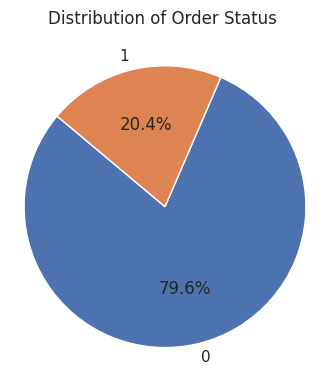

In [6]:
plt.figure(figsize=(4,4))
output_counts = df['Exited'].value_counts()
plt.pie(output_counts, labels=output_counts.index, autopct='%1.1f%%', startangle=140)

plt.axis('equal')
plt.title('Distribution of Order Status \n')
plt.ylabel('')

plt.show()

#### Observation:
    
The target column looks imbalanced - accuracy would not be a good metric to evaluate the model and we would need to apply balancing techniques like SMOTE while modeling

Box plot for numerical features:


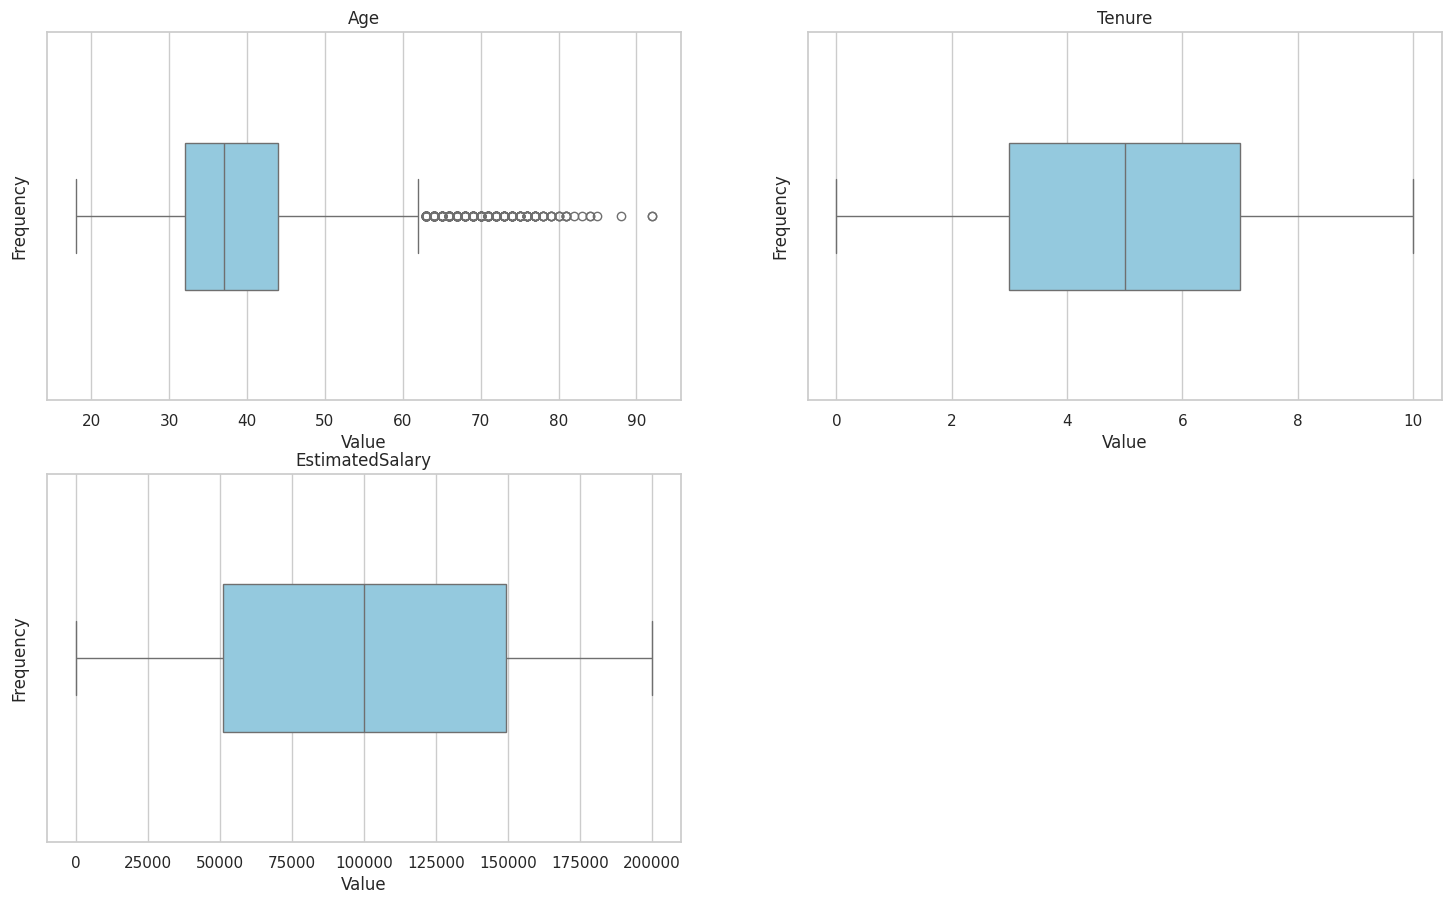

In [7]:
print("Box plot for numerical features:")
plt.figure(figsize=(18,22))
numeric_features = ['Age','Tenure','EstimatedSalary']
for i, column in enumerate(numeric_features):
    plt.subplot(4,2, i + 1)
    sns.boxplot(x=df[column], color='skyblue', width=0.4)
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

#### Observation:
    
It does not look like there are many outliers in the numerical features, except Age - but we can't do much about it

Count plot for categorical features:


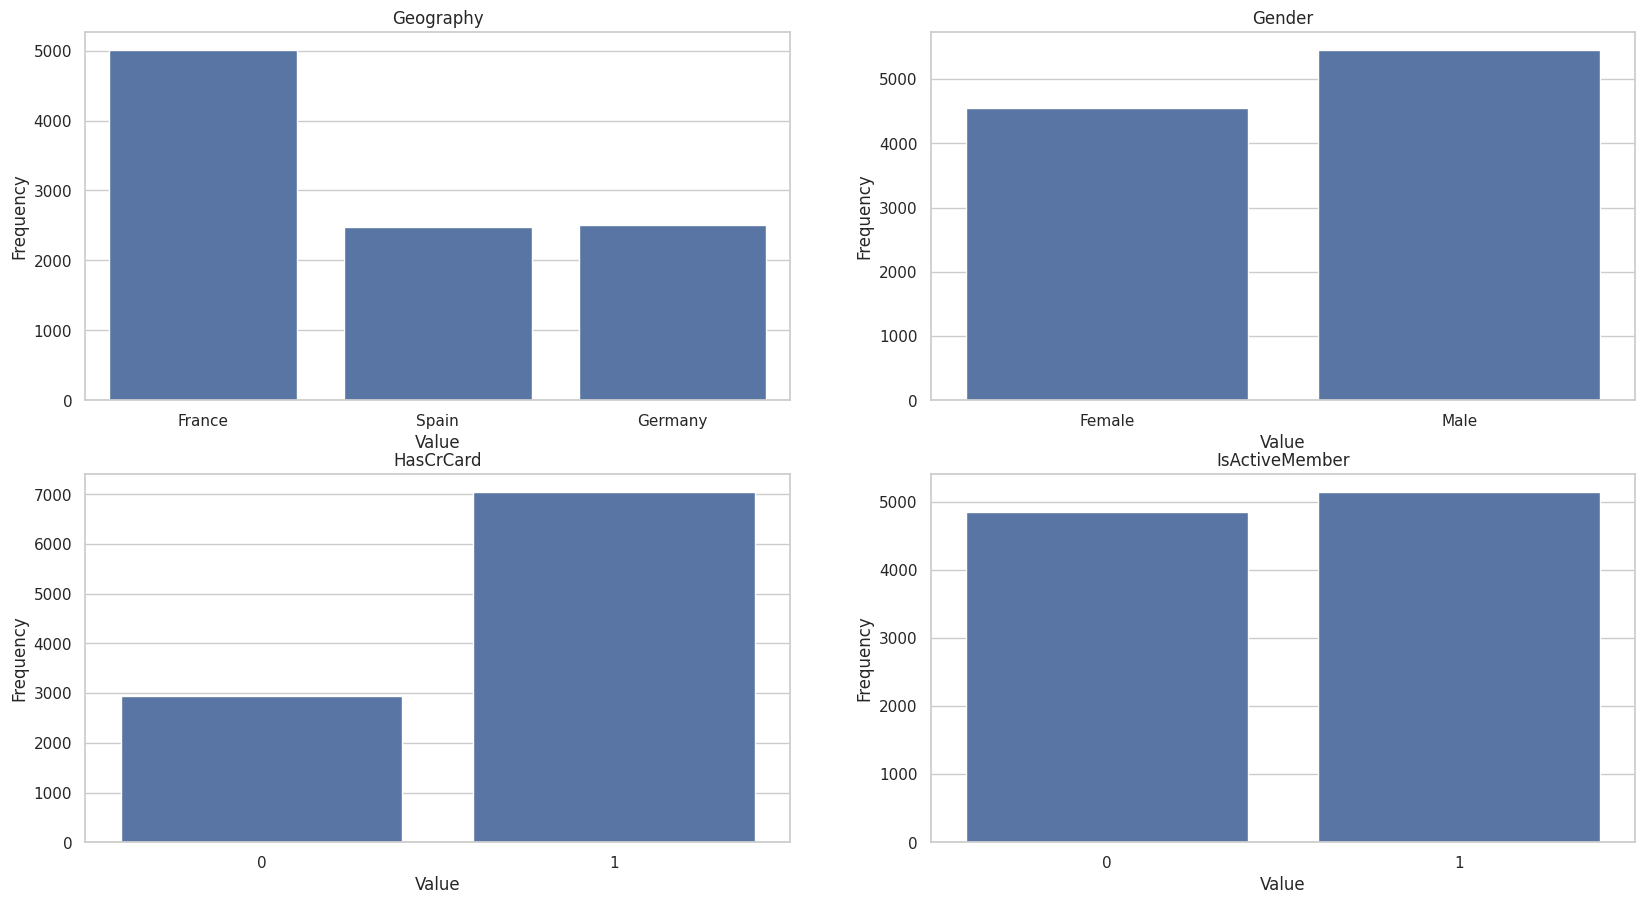

In [8]:
print("Count plot for categorical features:")
plt.figure(figsize=(20,22))

for i, column in enumerate(['Geography','Gender','HasCrCard','IsActiveMember']):
    plt.subplot(4,2,i + 1)
    sns.countplot(x= df[column], data=df)
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

#### Observation:
    
The count plots indicate that there are more customers from France than Spain or Germany, the gender distribution is nearly balanced, most customers have a credit card, and there is a higher proportion of active members

Observing independent variables based on the Exited Column:


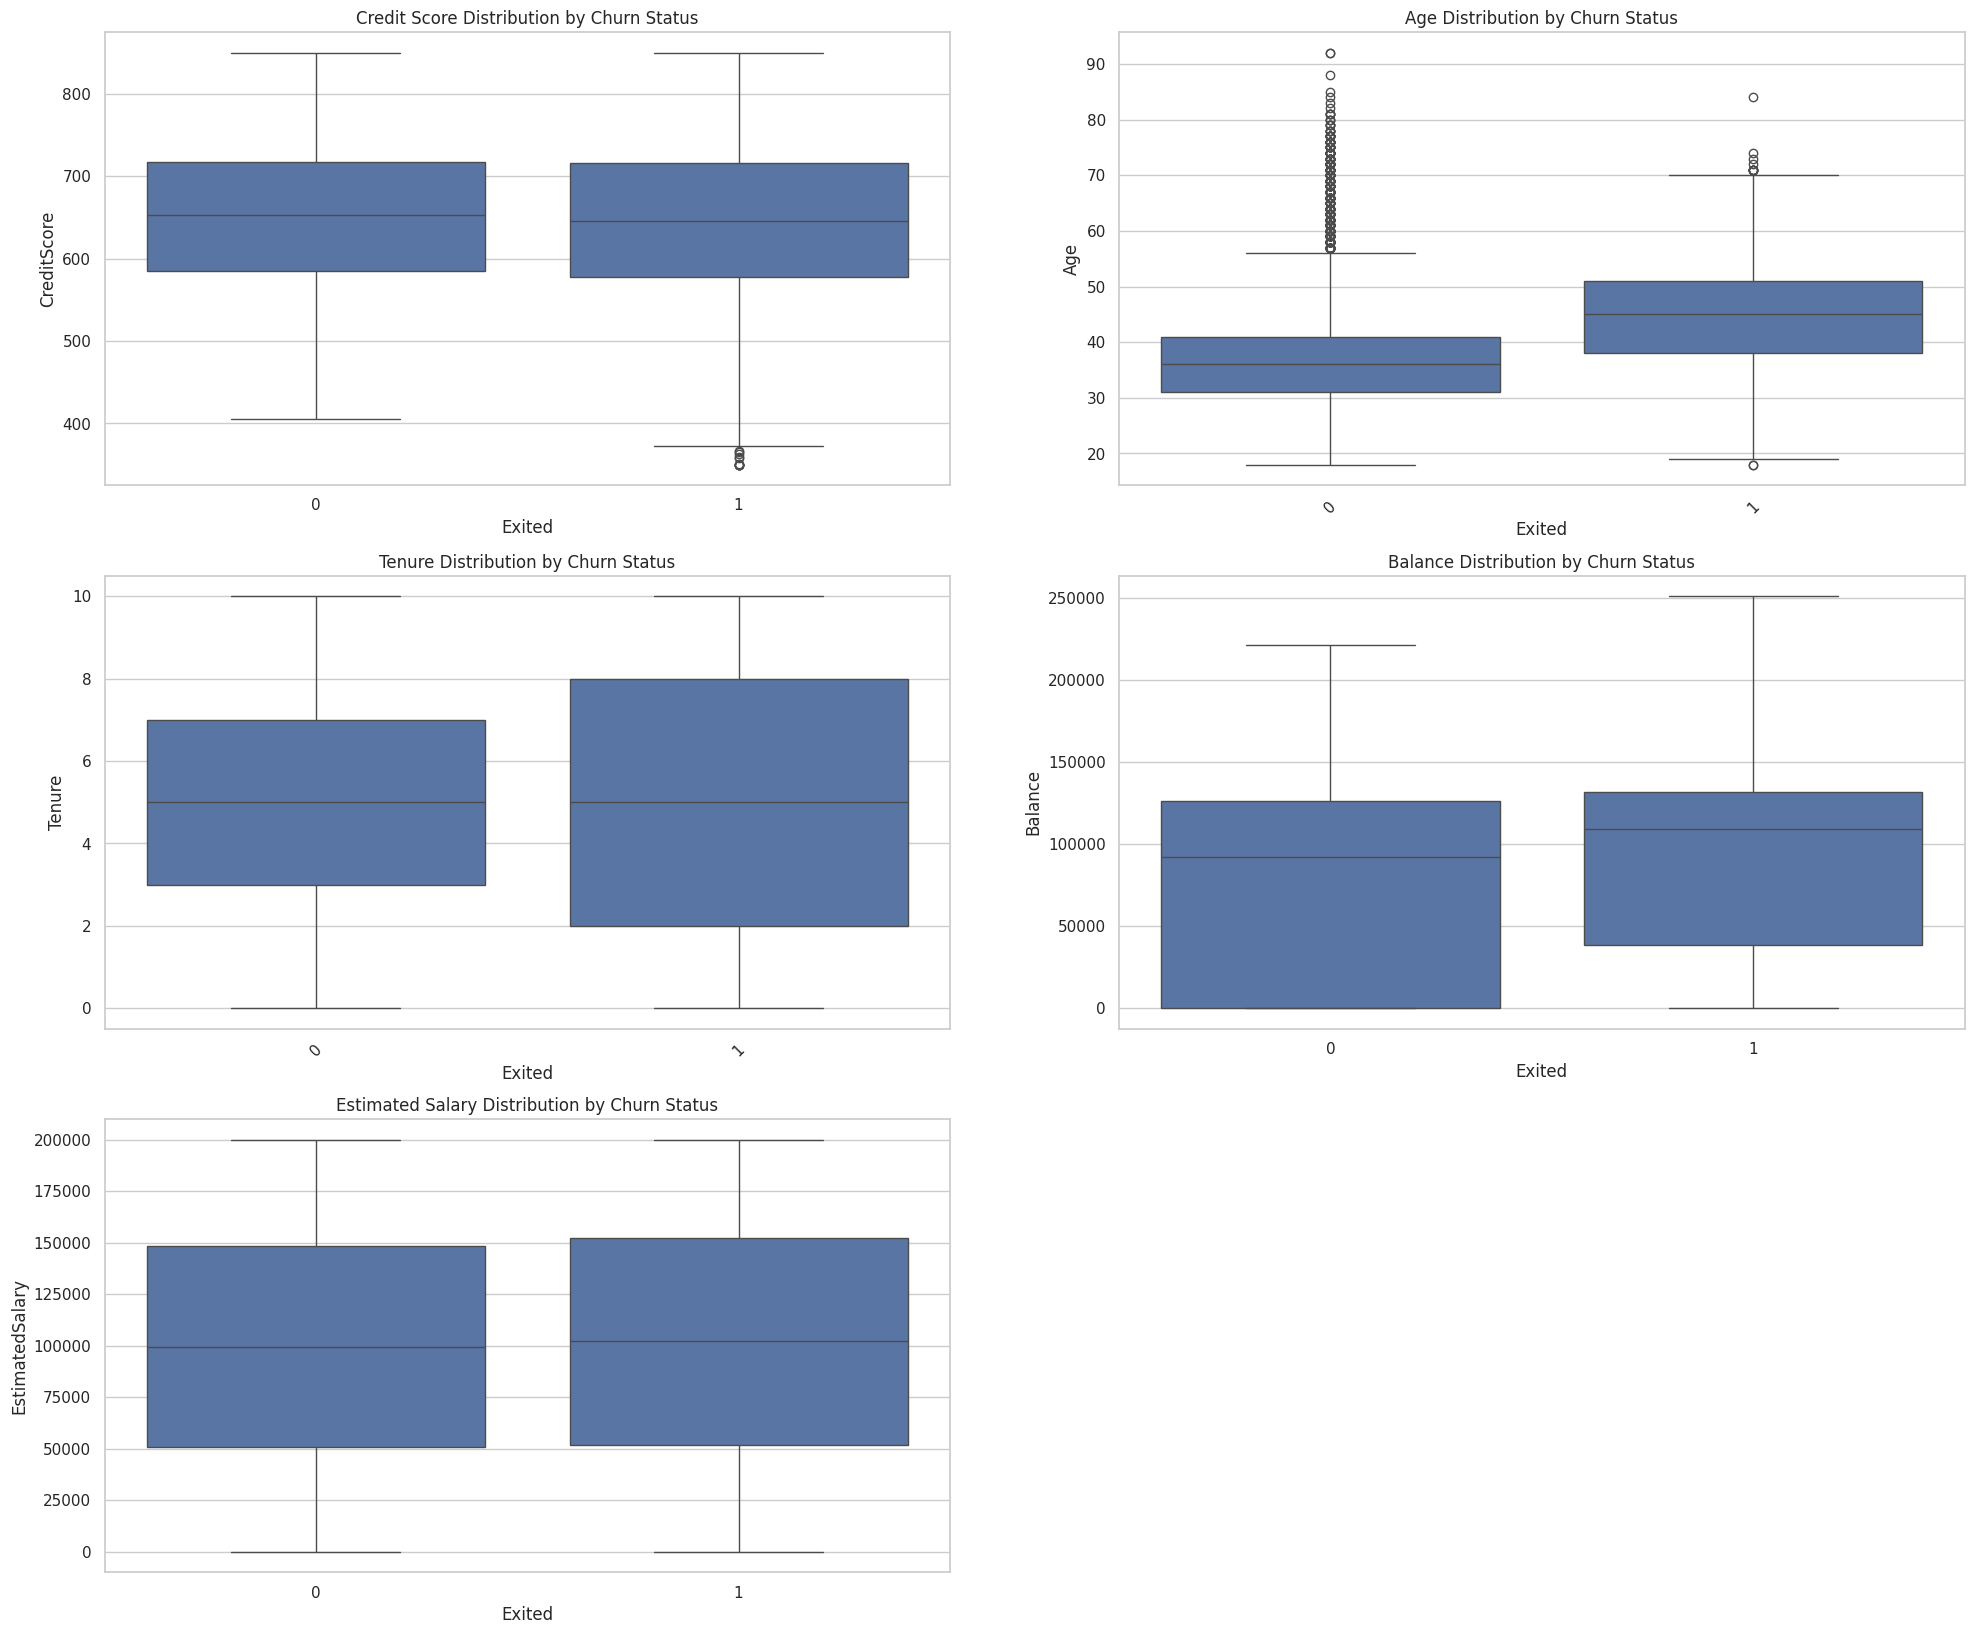

In [9]:
print("Observing independent variables based on the Exited Column:")

fig, axes = plt.subplots(3,2, figsize=(24,20))

sns.boxplot(data=df, y='CreditScore', x ='Exited',  ax=axes[0,0])
axes[0,0].set_title('Credit Score Distribution by Churn Status')

sns.boxplot(data=df, y='Age', x ='Exited', ax=axes[0,1])
axes[0,1].set_title('Age Distribution by Churn Status')
axes[0,1].tick_params(axis='x', rotation=45)

sns.boxplot(data=df, y='Tenure', x ='Exited', ax=axes[1,0])
axes[1,0].set_title('Tenure Distribution by Churn Status')
axes[1,0].tick_params(axis='x', rotation=45)

sns.boxplot(data=df, y='Balance', x ='Exited', ax=axes[1,1])
axes[1,1].set_title('Balance Distribution by Churn Status')

sns.boxplot(data=df, y='EstimatedSalary', x= 'Exited', ax=axes[2,0])
axes[2,0].set_title('Estimated Salary Distribution by Churn Status')

axes[2,1].axis('off')
plt.show()

#### Observation:

The credit score distribution between customers who churned and those who did not churn is similar, indicating that the credit score may not be a strong predictor of churn.

The tenure distribution suggests that customers with a shorter tenure are slightly more likely to churn than those with a longer tenure.

Age distribution shows a more pronounced difference - older customers appear more likely to churn than younger ones.

Lastly, the balance distribution is significantly different, with churned customers having higher balances on average. This could indicate that customers with higher balances are at a higher risk of churn.

The estimated salary distribution does not show a stark difference between the churned and retained customers, suggesting that salary may not be a primary factor in the decision to churn.

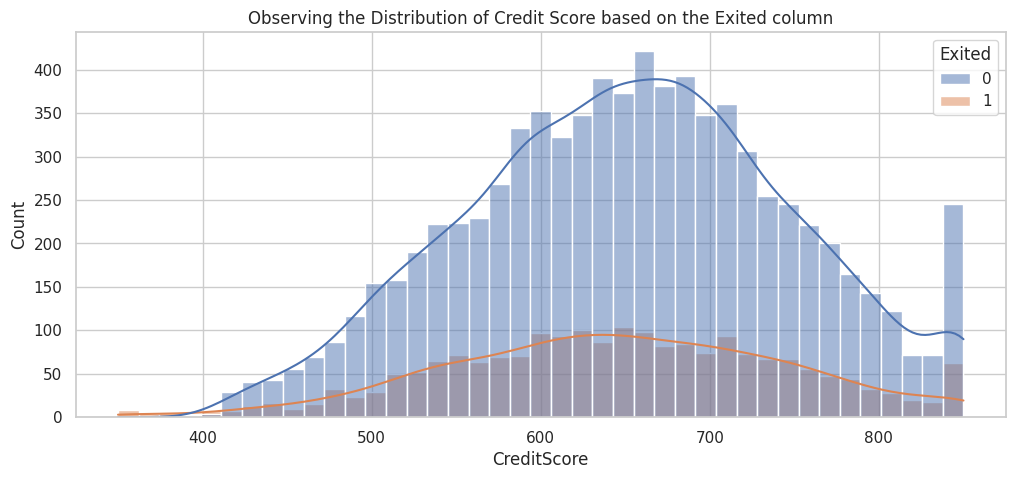

In [10]:
plt.figure(figsize=(12, 5))
sns.histplot(data=df, x='CreditScore', hue='Exited', kde=True)
plt.title('Observing the Distribution of Credit Score based on the Exited column')
plt.show()

#### Observation:

By observing the distribution of credit scores among customers who have churned versus those who haven't, we can see that there is no stark contrast between the two groups, implying that credit score alone may not be a strong predictor of churn within this dataset.

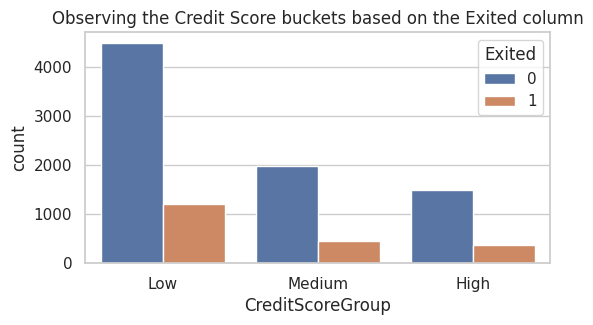

In [11]:
bins = [0,669,739,850]
labels = ['Low','Medium','High']

df['CreditScoreGroup'] = pd.cut(df['CreditScore'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(6,3))
sns.countplot(x = 'CreditScoreGroup', hue = 'Exited', data = df)
plt.title('Observing the Credit Score buckets based on the Exited column')
plt.show()

#### Observation:

Majority of customers who churned are in the 'High' credit score group, suggesting that credit score might have some influence on churn, albeit not a straightforward one

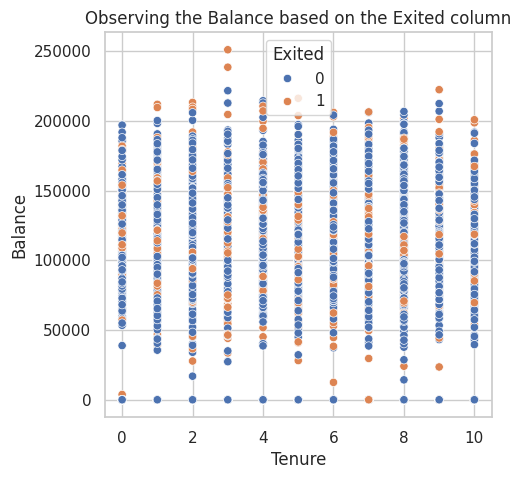

In [12]:
plt.figure(figsize=(5,5))
sns.scatterplot(x='Tenure', y='Balance', hue='Exited', data=df)
plt.title('Observing the Balance based on the Exited column')
plt.show()

#### Observation:

The scatter plot indicates that there is no clear pattern or correlation between tenure and balance for both churned and retained customers, implying these factors independently do not strongly predict customer churn

## Feature Engineering

### *Exploring the relationship between features*

a. **Credit Utilization**: Ratio of balance to credit score. It can give an insight into how much of the available credit the customer is using

b. **Interaction Score**: A composite score based on the number of products, active membership, and credit card possession which can give a holistic view of a customer's engagement with the bank. Higher engagement levels might be associated with lower churn rates

c. **Balance To Salary Ratio**: Ratio of the customer's balance to their estimated salary. This feature can indicate how significant the customer's balance is in relation to their income

d. **Credit Score Age Interaction**: An interaction term between credit score and age to explore if the impact of credit score on churn varies across different age groups

In [13]:
df['CreditUtilization']=df['Balance']/df['CreditScore']

df['InteractionScore']=df['NumOfProducts']+df['HasCrCard']+df['IsActiveMember']

df['BalanceToSalaryRatio']=df['Balance']/df['EstimatedSalary']

df['CreditScoreAgeInteraction']=df['CreditScore']*df['Age']

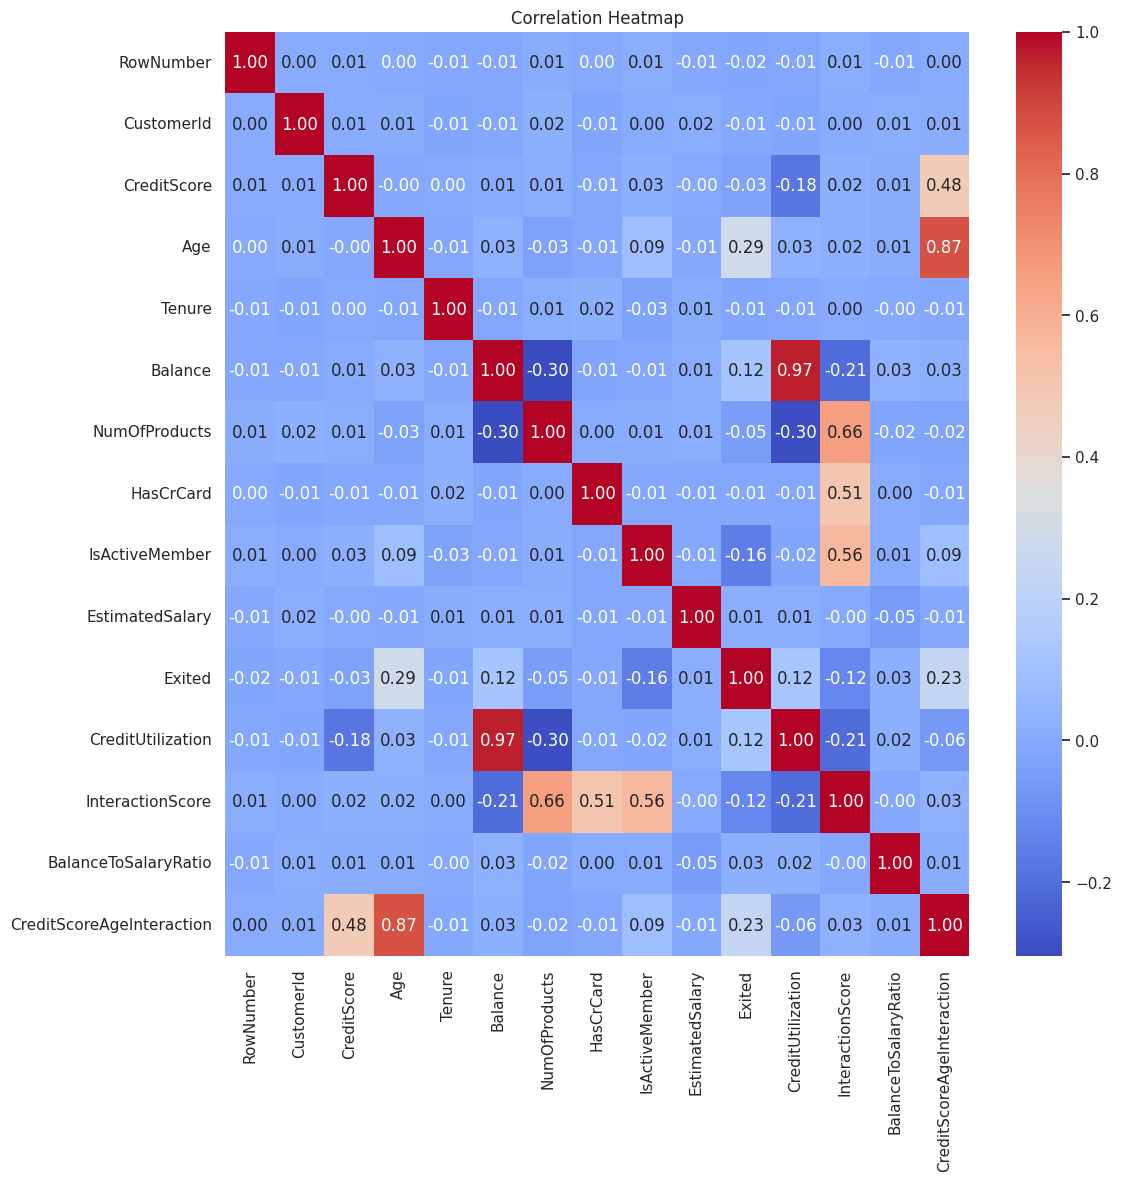

In [ ]:
plt.figure(figsize=(8, 8))
numeric_df = df.select_dtypes(include=[np.number])  # Only keep numeric columns
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

#### Observations:

Notable correlations include a moderate positive relationship between Age and Exited, suggesting older customers are more likely to churn, and a strong positive relationship between Balance and CreditUtilization, which is intuitive as higher balances would likely increase credit utilization rates

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   RowNumber                  10000 non-null  int64   
 1   CustomerId                 10000 non-null  int64   
 2   Surname                    10000 non-null  object  
 3   CreditScore                10000 non-null  int64   
 4   Geography                  10000 non-null  object  
 5   Gender                     10000 non-null  object  
 6   Age                        10000 non-null  int64   
 7   Tenure                     10000 non-null  int64   
 8   Balance                    10000 non-null  float64 
 9   NumOfProducts              10000 non-null  int64   
 10  HasCrCard                  10000 non-null  int64   
 11  IsActiveMember             10000 non-null  int64   
 12  EstimatedSalary            10000 non-null  float64 
 13  Exited                     10000

In [26]:
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
target_correlations = correlation_matrix['Exited']
print(target_correlations)

RowNumber                   -0.016571
CustomerId                  -0.006248
CreditScore                 -0.027094
Age                          0.285323
Tenure                      -0.014001
Balance                      0.118533
NumOfProducts               -0.047820
HasCrCard                   -0.007138
IsActiveMember              -0.156128
EstimatedSalary              0.012097
Exited                       1.000000
CreditUtilization            0.121692
InteractionScore            -0.122148
BalanceToSalaryRatio         0.025558
CreditScoreAgeInteraction    0.232030
Name: Exited, dtype: float64


#### Observation:

1. Age shows a moderately positive correlation, suggesting older customers are more likely to churn 
2. IsActiveMember has a negative correlation, indicating that active members are less likely to churn
3. High CreditUtilization and NumOfProducts also appear to be associated with a higher likelihood of churning

## Modeling

In [27]:
cat_col = ['Geography','Gender','CreditScoreGroup']

print("Observing the categorical column disribution before encoding: \n")
for columns in cat_col:
    print(columns, '\n')
    print(df[columns].value_counts(),'\n')

Observing the categorical column disribution before encoding: 

Geography 

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64 

Gender 

Gender
Male      5457
Female    4543
Name: count, dtype: int64 

CreditScoreGroup 

CreditScoreGroup
Low       5693
Medium    2428
High      1879
Name: count, dtype: int64 



In [28]:
encoder = LabelEncoder()

for columns in cat_col:
    df[columns] = encoder.fit_transform(df[columns])

print("Observing the categorical column disribution after encoding: \n")    
for columns in cat_col:
    print(columns, '\n')
    print(df[columns].value_counts(),'\n')

Observing the categorical column disribution after encoding: 

Geography 

Geography
0    5014
1    2509
2    2477
Name: count, dtype: int64 

Gender 

Gender
1    5457
0    4543
Name: count, dtype: int64 

CreditScoreGroup 

CreditScoreGroup
1    5693
2    2428
0    1879
Name: count, dtype: int64 



In [29]:
col_drop = ['Exited','RowNumber','CustomerId','Surname']
X = df.drop(col_drop, axis=1)
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaling_columns = ['Age','CreditScore','Balance','EstimatedSalary','CreditUtilization','BalanceToSalaryRatio','CreditScoreAgeInteraction']

scaler = StandardScaler()
scaler.fit(X_train[scaling_columns])

X_train[scaling_columns] = scaler.transform(X_train[scaling_columns])
X_test[scaling_columns] = scaler.transform(X_test[scaling_columns])

In [30]:
print("Training dataset shape:", X_train.shape, y_train.shape)
print("Test dataset shape:",X_test.shape, y_test.shape)

Training dataset shape: (7000, 15) (7000,)
Test dataset shape: (3000, 15) (3000,)


In [33]:
results_df = pd.DataFrame(columns=['Model','Accuracy','Recall Score','F1 Score','ROC AUC Score'])

for name, model in models.items():
    print(f"\nModel: {name}")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        roc_auc = None
    
    results_df.loc[len(results_df)] = [name, accuracy, recall, f1, roc_auc]
    print(f"Accuracy: {accuracy:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | ROC AUC: {roc_auc if roc_auc else 'N/A'}")
    print("-" * 50)



Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      2416
           1       0.36      0.68      0.47       584

    accuracy                           0.70      3000
   macro avg       0.63      0.70      0.63      3000
weighted avg       0.80      0.70      0.73      3000

Confusion Matrix:
[[1712  704]
 [ 185  399]]
Accuracy: 0.7037 | Recall: 0.6832 | F1: 0.4730 | ROC AUC: 0.7640820613716774
--------------------------------------------------

Model: Random Forest


              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2416
           1       0.79      0.42      0.55       584

    accuracy                           0.87      3000
   macro avg       0.83      0.70      0.74      3000
weighted avg       0.86      0.87      0.85      3000

Confusion Matrix:
[[2351   65]
 [ 337  247]]
Accuracy: 0.8660 | Recall: 0.4229 | F1: 0.5513 | ROC AUC: 0.8545059194411686
--------------------------------------------------

Model: K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.91      0.77      0.83      2416
           1       0.42      0.67      0.51       584

    accuracy                           0.75      3000
   macro avg       0.66      0.72      0.67      3000
weighted avg       0.81      0.75      0.77      3000

Confusion Matrix:
[[1867  549]
 [ 194  390]]
Accuracy: 0.7523 | Recall: 0.6678 | F1: 0.5121 | ROC AUC: 0.7766385483761227
-----------------------

In [34]:
results_df

,Model,Accuracy,Recall Score,F1 Score,ROC AUC Score
0,Logistic Regression,0.703667,0.683219,0.473029,0.764082
1,Random Forest,0.866000,0.422945,0.551339,0.854506
2,K-Nearest Neighbors,0.752333,0.667808,0.512147,0.776639
3,Support Vector Machine,0.785667,0.662671,0.546224,0.822500
4,XGBoost,0.833000,0.609589,0.586974,0.841784
5,Gradient Boosting,0.817000,0.700342,0.598391,0.859767


From the results of the classification models on the churn prediction dataset, we can infer the following:

1. **Gradient Boosting** has the highest F1 score (0.598391) and the highest ROC AUC score (0.859767) among all the models. This suggests that Gradient Boosting is the most effective model in balancing precision and recall and has the best ability to distinguish between the churned and non-churned customers.

2. **XGBoost** also performs well, with a relatively high F1 score (0.586974) and a good ROC AUC score (0.841784). This indicates that XGBoost is another strong model for this task.

3. **Random Forest** has a high accuracy (0.862000) but a lower F1 score (0.551339) compared to Gradient Boosting and XGBoost. This suggests that while Random Forest is good at predicting the majority class (non-churned customers), it might not be as effective at identifying the minority class (churned customers).

4. **Support Vector Machine** and **K-Nearest Neighbors** have moderate F1 scores and ROC AUC scores. They perform better than Logistic Regression but are not as effective as Gradient Boosting or XGBoost for this dataset.

5. **Logistic Regression** has the lowest accuracy (0.703667), F1 score (0.473029), and ROC AUC score (0.764076) among all the models. This indicates that Logistic Regression is the least effective model for predicting customer churn in this dataset.

#### Overall:

Gradient Boosting appears to be the best model for this churn prediction task, followed closely by XGBoost. These models are able to better handle the class imbalance and provide a good balance between precision and recall. 

In [35]:
import joblib

# Assuming this is the model instance you've trained
best_model = GradientBoostingClassifier(random_state=42)
best_model.fit(X_train, y_train)

# Save to file
joblib.dump(best_model, 'gradient_boosting_churn_model.pkl')
print("Model saved successfully as gradient_boosting_churn_model.pkl")


Model saved successfully as gradient_boosting_churn_model.pkl
